# Machine Learning Models

This notebook contains the implementation and evaluation of various machine learning models for match prediction using the engineered features.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
np.random.seed(42)

## Load the Training and Test Sets

In [3]:
# Load the training and test sets from the Features folder
X_train = pd.read_csv('Features/TrainingSet/features_scaled.csv')
y_train = pd.read_csv('Features/TrainingSet/matches_engineered.csv')['FTR']
X_val = pd.read_csv('Features/ValidationSet/features_scaled.csv')
y_val = pd.read_csv('Features/ValidationSet/matches_engineered.csv')['FTR']
X_test = pd.read_csv('Features/TestSet/features_scaled.csv')
y_test = pd.read_csv('Features/TestSet/matches_engineered.csv')['FTR']

# Convert target variables to numpy arrays if they're dataframes
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.values.ravel()
if isinstance(y_val, pd.DataFrame):
    y_val = y_val.values.ravel()
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values.ravel()

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Target distribution in training set:\n{pd.Series(y_train).value_counts(normalize=True)}")

Training set shape: (1520, 17)
Validation set shape: (380, 17)
Test set shape: (380, 17)
Target distribution in training set:
FTR
H    0.457237
A    0.280921
D    0.261842
Name: proportion, dtype: float64


## Helper Functions for Model Evaluation

In [4]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test=None, y_test=None):
    """Evaluate a model on training and validation sets, optionally on test set."""
    # Training set performance
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    
    # Validation set performance
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    # Create results dictionary
    results = {
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    }
    
    # Test set performance (if provided)
    if X_test is not None and y_test is not None:
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, average='weighted')
        test_recall = recall_score(y_test, y_test_pred, average='weighted')
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')
        
        results.update({
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1
        })
    
    return results

def plot_confusion_matrix(model, X, y, title='Confusion Matrix'):
    """Plot confusion matrix for a model's predictions."""
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(classification_report(y, y_pred))

def plot_feature_importance(model, feature_names, top_n=20, title='Feature Importance'):
    """Plot feature importance for tree-based models."""
    if hasattr(model, 'feature_importances_'):
        # Get feature importances
        importances = model.feature_importances_
        
        # Create DataFrame for better visualization
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot top N features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
        plt.title(title)
        plt.tight_layout()
        plt.show()
        
        return feature_importance_df
    else:
        print("This model doesn't have feature_importances_ attribute.")
        return None

## Random Forest Classifier

Random Forest Results:
train_accuracy: 0.9954
train_precision: 0.9954
train_recall: 0.9954
train_f1: 0.9954
val_accuracy: 0.4447
val_precision: 0.3938
val_recall: 0.4447
val_f1: 0.4004


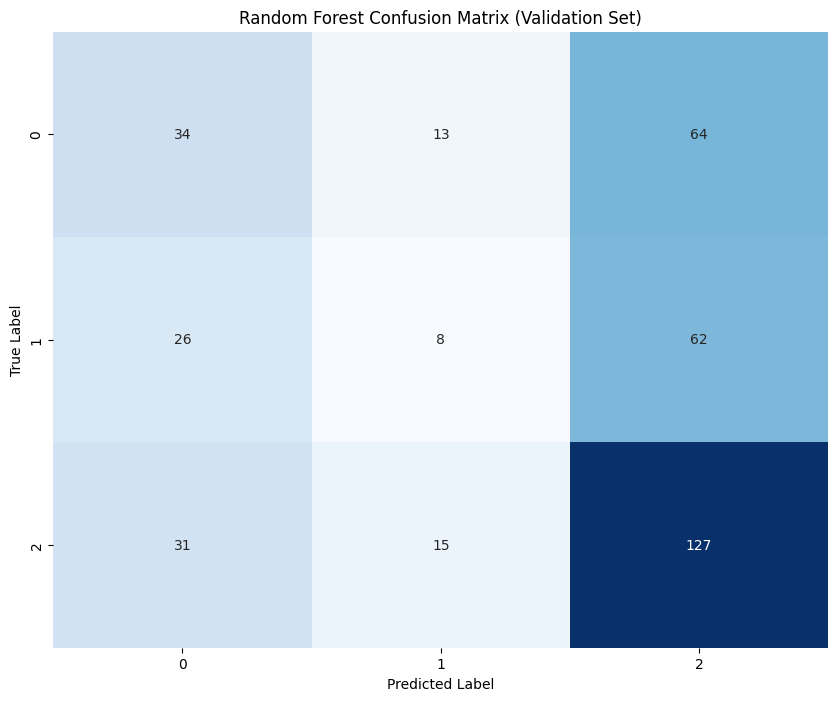

              precision    recall  f1-score   support

           A       0.37      0.31      0.34       111
           D       0.22      0.08      0.12        96
           H       0.50      0.73      0.60       173

    accuracy                           0.44       380
   macro avg       0.37      0.37      0.35       380
weighted avg       0.39      0.44      0.40       380



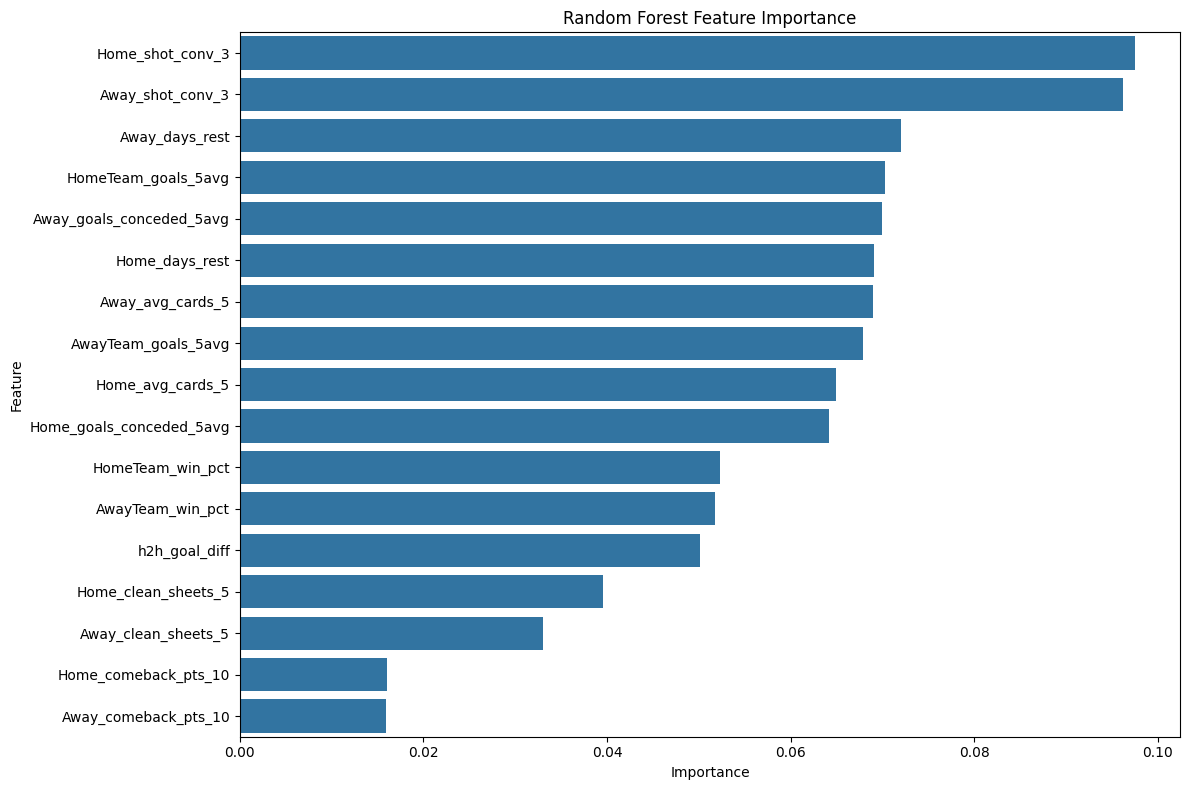

In [5]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate the model
rf_results = evaluate_model(rf_model, X_train, y_train, X_val, y_val)
print("Random Forest Results:")
for metric, value in rf_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(rf_model, X_val, y_val, title='Random Forest Confusion Matrix (Validation Set)')

# Plot feature importance
rf_feature_importance = plot_feature_importance(rf_model, X_train.columns, title='Random Forest Feature Importance')

## Gradient Boosting Classifier

Gradient Boosting Results:
train_accuracy: 0.6993
train_precision: 0.7239
train_recall: 0.6993
train_f1: 0.6845
val_accuracy: 0.4605
val_precision: 0.4208
val_recall: 0.4605
val_f1: 0.4259


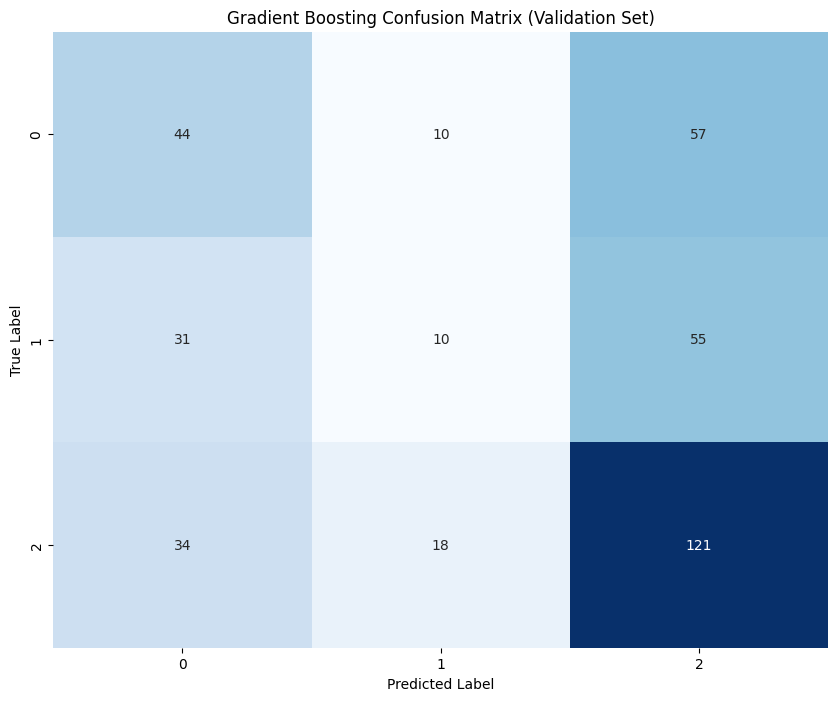

              precision    recall  f1-score   support

           A       0.40      0.40      0.40       111
           D       0.26      0.10      0.15        96
           H       0.52      0.70      0.60       173

    accuracy                           0.46       380
   macro avg       0.40      0.40      0.38       380
weighted avg       0.42      0.46      0.43       380



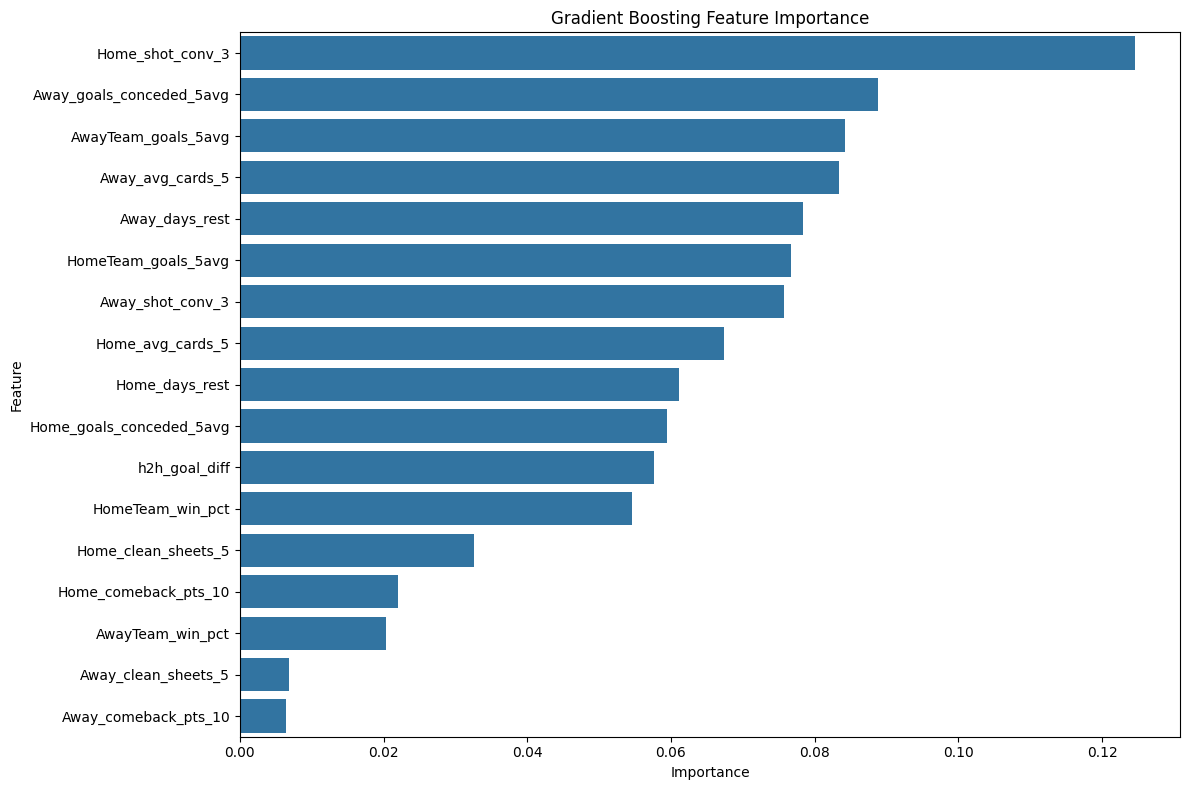

In [6]:
# Initialize and train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Evaluate the model
gb_results = evaluate_model(gb_model, X_train, y_train, X_val, y_val)
print("Gradient Boosting Results:")
for metric, value in gb_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(gb_model, X_val, y_val, title='Gradient Boosting Confusion Matrix (Validation Set)')

# Plot feature importance
gb_feature_importance = plot_feature_importance(gb_model, X_train.columns, title='Gradient Boosting Feature Importance')

## XGBoost Classifier

In [8]:
# Initialize a LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Transform string labels to numbers for training
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Initialize and train XGBoost model with encoded labels
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train_encoded)

# For evaluation, we need to modify the evaluate_model function to handle encoded labels
# But for now, let's manually calculate the metrics
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

# Convert predictions back to original labels for interpretability
y_train_pred_original = label_encoder.inverse_transform(y_train_pred)
y_val_pred_original = label_encoder.inverse_transform(y_val_pred)

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_accuracy = accuracy_score(y_train, y_train_pred_original)
train_precision = precision_score(y_train, y_train_pred_original, average='weighted')
train_recall = recall_score(y_train, y_train_pred_original, average='weighted')
train_f1 = f1_score(y_train, y_train_pred_original, average='weighted')

val_accuracy = accuracy_score(y_val, y_val_pred_original)
val_precision = precision_score(y_val, y_val_pred_original, average='weighted')
val_recall = recall_score(y_val, y_val_pred_original, average='weighted')
val_f1 = f1_score(y_val, y_val_pred_original, average='weighted')

# Print results
print("XGBoost Results:")
print(f"train_accuracy: {train_accuracy:.4f}")
print(f"train_precision: {train_precision:.4f}")
print(f"train_recall: {train_recall:.4f}")
print(f"train_f1: {train_f1:.4f}")
print(f"val_accuracy: {val_accuracy:.4f}")
print(f"val_precision: {val_precision:.4f}")
print(f"val_recall: {val_recall:.4f}")
print(f"val_f1: {val_f1:.4f}")

# Plot confusion matrix (modified to use encoded labels)
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_val, 
    y_val_pred_original,
    ax=ax,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Blues
)
plt.title('XGBoost Confusion Matrix (Validation Set)')
plt.show()

# Plot feature importance
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(12, 8))
plt.title('XGBoost Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['A' 'D' 'H']

## LightGBM Classifier

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 17
[LightGBM] [Info] Start training from score -1.269682
[LightGBM] [Info] Start training from score -1.340014
[LightGBM] [Info] Start training from score -0.782554
LightGBM Results:
train_accuracy: 0.9954
train_precision: 0.9954
train_recall: 0.9954
train_f1: 0.9954
val_accuracy: 0.4263
val_precision: 0.4081
val_recall: 0.4263
val_f1: 0.4108


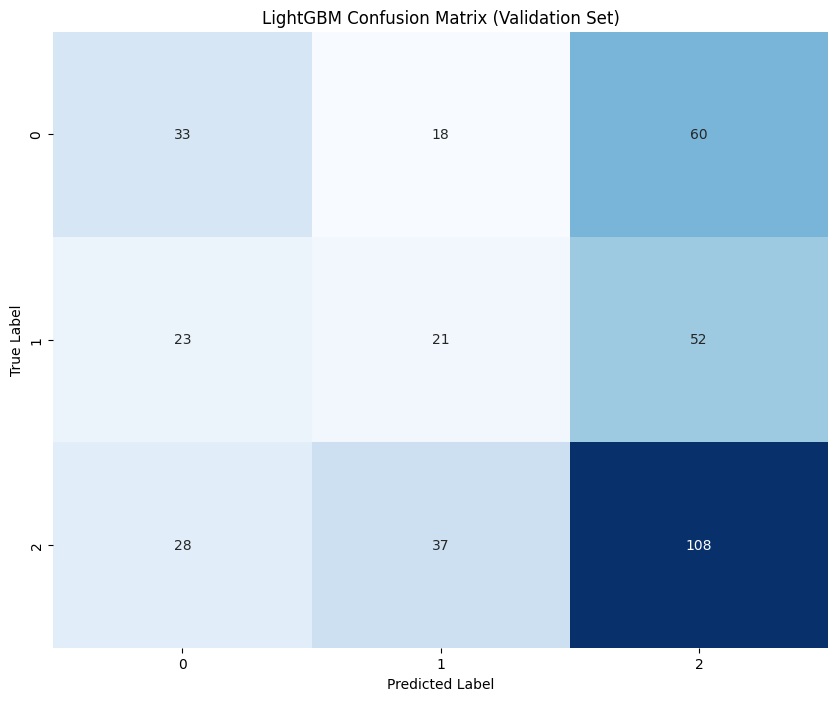

              precision    recall  f1-score   support

           A       0.39      0.30      0.34       111
           D       0.28      0.22      0.24        96
           H       0.49      0.62      0.55       173

    accuracy                           0.43       380
   macro avg       0.39      0.38      0.38       380
weighted avg       0.41      0.43      0.41       380



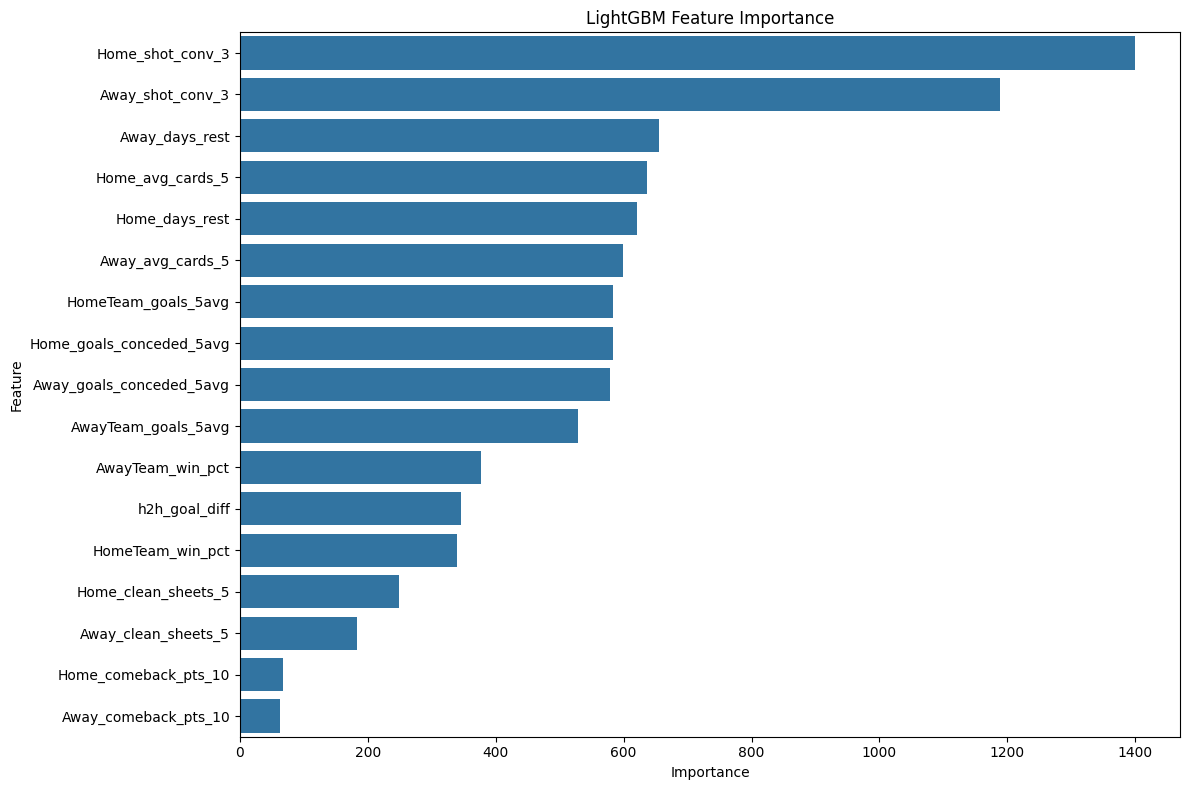

In [9]:
# Initialize and train LightGBM model
lgbm_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(X_train, y_train)

# Evaluate the model
lgbm_results = evaluate_model(lgbm_model, X_train, y_train, X_val, y_val)
print("LightGBM Results:")
for metric, value in lgbm_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(lgbm_model, X_val, y_val, title='LightGBM Confusion Matrix (Validation Set)')

# Plot feature importance
lgbm_feature_importance = plot_feature_importance(lgbm_model, X_train.columns, title='LightGBM Feature Importance')

## Logistic Regression

Logistic Regression Results:
train_accuracy: 0.4829
train_precision: 0.4678
train_recall: 0.4829
train_f1: 0.3978
val_accuracy: 0.4553
val_precision: 0.3930
val_recall: 0.4553
val_f1: 0.3911


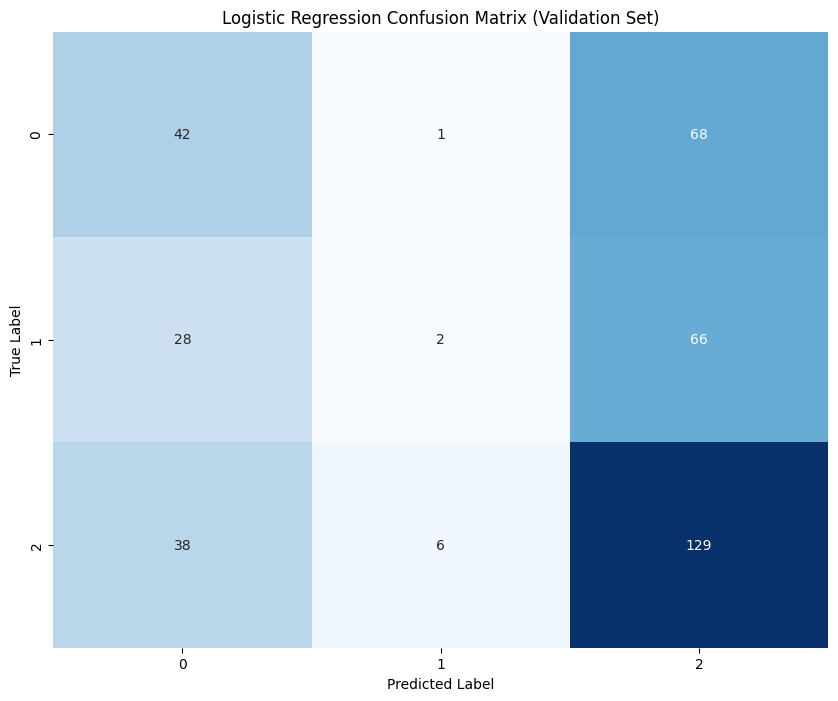

              precision    recall  f1-score   support

           A       0.39      0.38      0.38       111
           D       0.22      0.02      0.04        96
           H       0.49      0.75      0.59       173

    accuracy                           0.46       380
   macro avg       0.37      0.38      0.34       380
weighted avg       0.39      0.46      0.39       380



In [10]:
# Initialize and train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train, y_train)

# Evaluate the model
lr_results = evaluate_model(lr_model, X_train, y_train, X_val, y_val)
print("Logistic Regression Results:")
for metric, value in lr_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(lr_model, X_val, y_val, title='Logistic Regression Confusion Matrix (Validation Set)')

## Support Vector Machine

SVM Results:
train_accuracy: 0.5704
train_precision: 0.6524
train_recall: 0.5704
train_f1: 0.5070
val_accuracy: 0.4316
val_precision: 0.2657
val_recall: 0.4316
val_f1: 0.3015


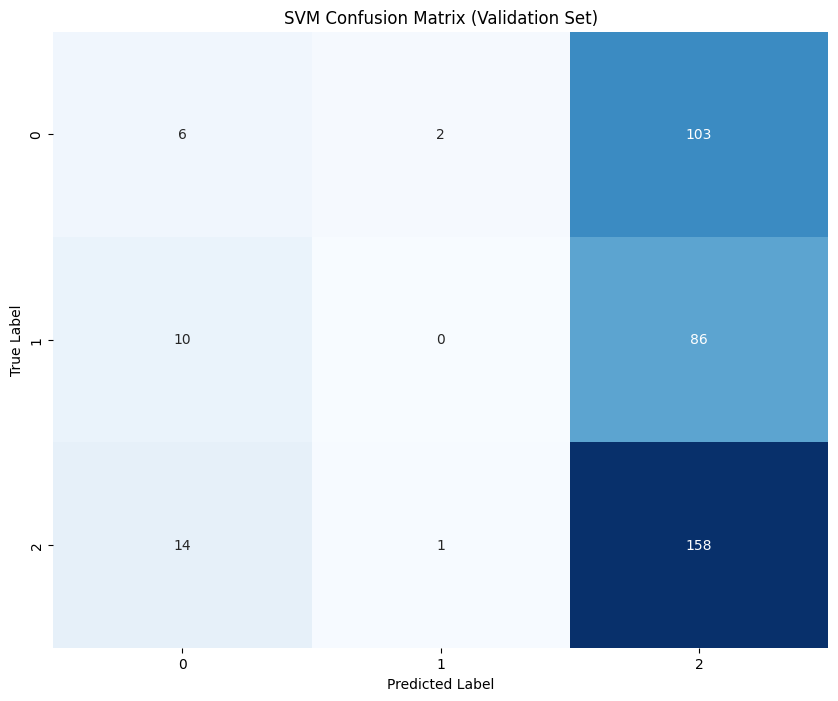

              precision    recall  f1-score   support

           A       0.20      0.05      0.09       111
           D       0.00      0.00      0.00        96
           H       0.46      0.91      0.61       173

    accuracy                           0.43       380
   macro avg       0.22      0.32      0.23       380
weighted avg       0.27      0.43      0.30       380



In [11]:
# Initialize and train SVM model
# Note: SVM can be slow on large datasets, so we'll use a smaller subset if needed
if X_train.shape[0] > 10000:
    print("SVM might be slow on this dataset. Consider using a smaller subset or different model.")

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Evaluate the model
svm_results = evaluate_model(svm_model, X_train, y_train, X_val, y_val)
print("SVM Results:")
for metric, value in svm_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(svm_model, X_val, y_val, title='SVM Confusion Matrix (Validation Set)')

## Neural Network (MLP Classifier)

Neural Network Results:
train_accuracy: 0.9954
train_precision: 0.9954
train_recall: 0.9954
train_f1: 0.9954
val_accuracy: 0.3842
val_precision: 0.3780
val_recall: 0.3842
val_f1: 0.3779


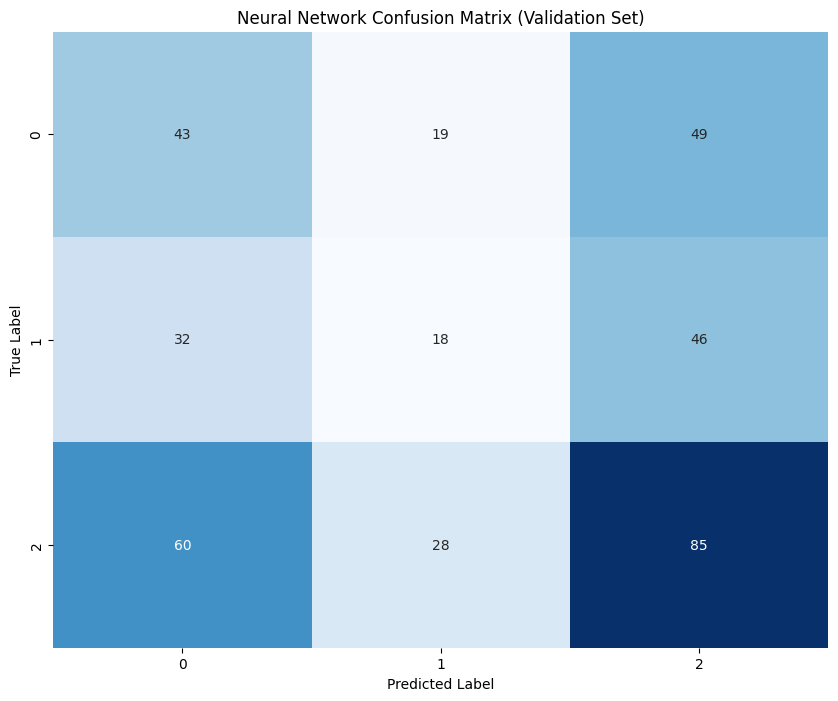

              precision    recall  f1-score   support

           A       0.32      0.39      0.35       111
           D       0.28      0.19      0.22        96
           H       0.47      0.49      0.48       173

    accuracy                           0.38       380
   macro avg       0.36      0.36      0.35       380
weighted avg       0.38      0.38      0.38       380



In [12]:
# Initialize and train Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)

# Evaluate the model
nn_results = evaluate_model(nn_model, X_train, y_train, X_val, y_val)
print("Neural Network Results:")
for metric, value in nn_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(nn_model, X_val, y_val, title='Neural Network Confusion Matrix (Validation Set)')

## Model Comparison

<Figure size 1400x800 with 0 Axes>

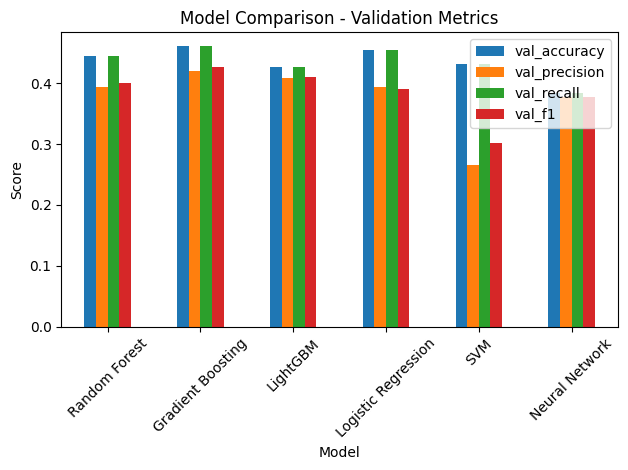

,train_accuracy,train_precision,train_recall,train_f1,val_accuracy,val_precision,val_recall,val_f1
Random Forest,0.995395,0.995441,0.995395,0.995396,0.444737,0.393810,0.444737,0.400402
Gradient Boosting,0.699342,0.723887,0.699342,0.684497,0.460526,0.420820,0.460526,0.425912
LightGBM,0.995395,0.995441,0.995395,0.995396,0.426316,0.408055,0.426316,0.410776
Logistic Regression,0.482895,0.467802,0.482895,0.397813,0.455263,0.393041,0.455263,0.391063
SVM,0.570395,0.652448,0.570395,0.507026,0.431579,0.265717,0.431579,0.301520
Neural Network,0.995395,0.995409,0.995395,0.995396,0.384211,0.377986,0.384211,0.377856


In [14]:
# Collect all results
all_results = {
    'Random Forest': rf_results,
    'Gradient Boosting': gb_results,
    #'XGBoost': xgb_results,
    'LightGBM': lgbm_results,
    'Logistic Regression': lr_results,
    'SVM': svm_results,
    'Neural Network': nn_results
}

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(all_results).T

# Plot validation metrics for comparison
plt.figure(figsize=(14, 8))
comparison_df[['val_accuracy', 'val_precision', 'val_recall', 'val_f1']].plot(kind='bar')
plt.title('Model Comparison - Validation Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Display the comparison table
comparison_df

## Hyperparameter Tuning for Best Model

Best model based on validation F1 score: Gradient Boosting
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 5, 'learning_rate': 0.2}
Best cross-validation score: 0.4173

Tuned Model Results:
train_accuracy: 0.9954
train_precision: 0.9954
train_recall: 0.9954
train_f1: 0.9954
val_accuracy: 0.4289
val_precision: 0.4074
val_recall: 0.4289
val_f1: 0.4137


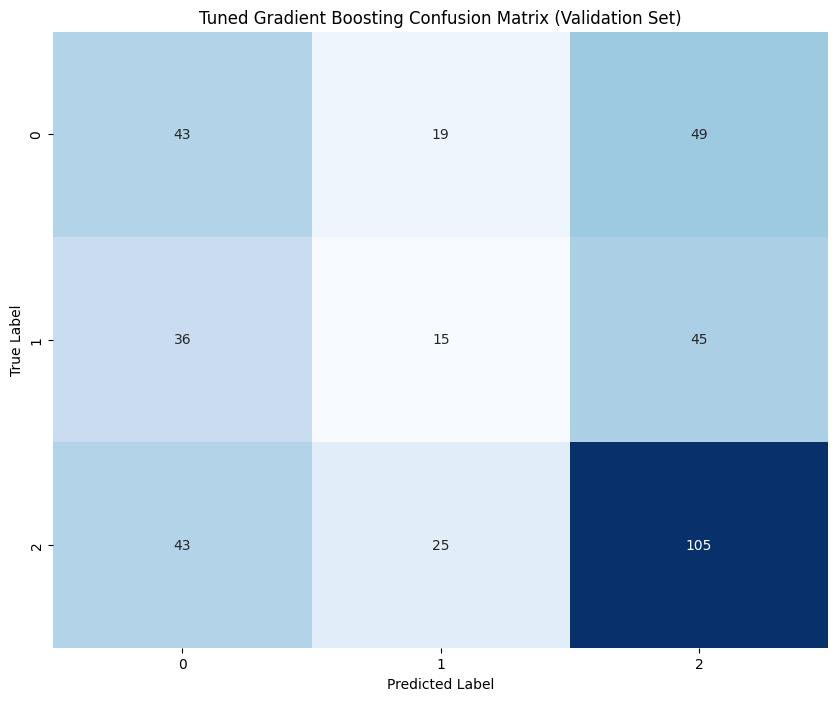

              precision    recall  f1-score   support

           A       0.35      0.39      0.37       111
           D       0.25      0.16      0.19        96
           H       0.53      0.61      0.56       173

    accuracy                           0.43       380
   macro avg       0.38      0.38      0.38       380
weighted avg       0.41      0.43      0.41       380



In [15]:
# Identify the best model based on validation F1 score
best_model_name = comparison_df['val_f1'].idxmax()
print(f"Best model based on validation F1 score: {best_model_name}")

# Define hyperparameter grid for the best model
if best_model_name == 'Random Forest':
    model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    model = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'XGBoost':
    model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 0.9]
    }
elif best_model_name == 'LightGBM':
    model = lgb.LGBMClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 100]
    }
elif best_model_name == 'Logistic Regression':
    model = LogisticRegression(random_state=42, max_iter=1000)
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
elif best_model_name == 'SVM':
    model = SVC(probability=True, random_state=42)
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
elif best_model_name == 'Neural Network':
    model = MLPClassifier(random_state=42, max_iter=500)
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }

# Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    model, param_grid, n_iter=20, cv=3, scoring='f1_weighted',
    random_state=42, n_jobs=-1, verbose=1
)

# Fit the random search
random_search.fit(X_train, y_train)

# Get the best parameters and model
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the tuned model
tuned_results = evaluate_model(best_model, X_train, y_train, X_val, y_val)
print("\nTuned Model Results:")
for metric, value in tuned_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix for the tuned model
plot_confusion_matrix(best_model, X_val, y_val, title=f'Tuned {best_model_name} Confusion Matrix (Validation Set)')

## Final Evaluation on Test Set

Final Model Results:
train_accuracy: 0.9954
train_precision: 0.9954
train_recall: 0.9954
train_f1: 0.9954
val_accuracy: 0.4289
val_precision: 0.4074
val_recall: 0.4289
val_f1: 0.4137
test_accuracy: 0.4079
test_precision: 0.4090
test_recall: 0.4079
test_f1: 0.3958


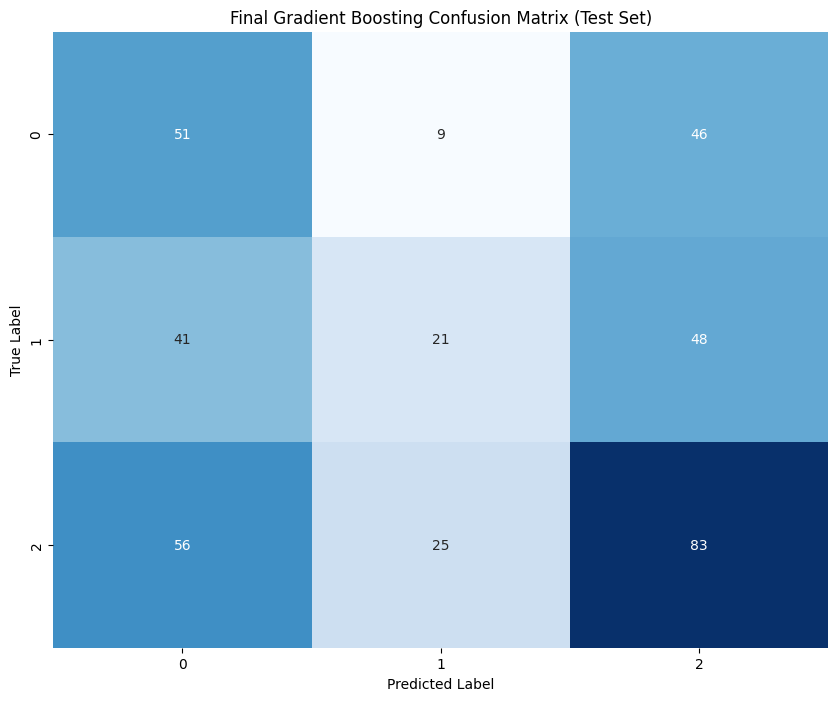

              precision    recall  f1-score   support

           A       0.34      0.48      0.40       106
           D       0.38      0.19      0.25       110
           H       0.47      0.51      0.49       164

    accuracy                           0.41       380
   macro avg       0.40      0.39      0.38       380
weighted avg       0.41      0.41      0.40       380



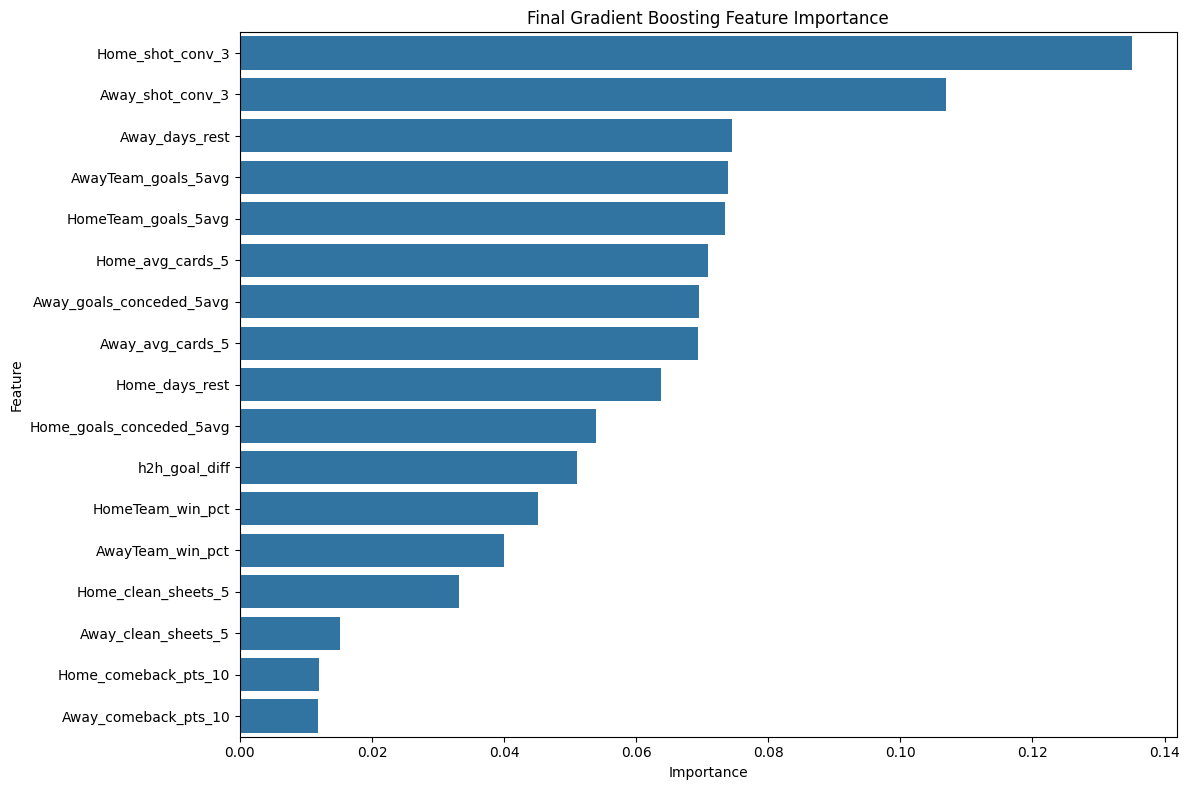

In [16]:
# Evaluate the best model on the test set
final_results = evaluate_model(best_model, X_train, y_train, X_val, y_val, X_test, y_test)
print("Final Model Results:")
for metric, value in final_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix for the test set
plot_confusion_matrix(best_model, X_test, y_test, title=f'Final {best_model_name} Confusion Matrix (Test Set)')

# If the best model is tree-based, plot feature importance
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    final_feature_importance = plot_feature_importance(best_model, X_train.columns, 
                                                      title=f'Final {best_model_name} Feature Importance')

## Save the Best Model

In [17]:
# Save the best model to disk
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"Best model saved as {model_filename}")

Best model saved as best_model_gradient_boosting.pkl


## Conclusion

In this notebook, we trained and evaluated several machine learning models for match prediction. We compared their performance, tuned the hyperparameters of the best model, and evaluated it on the test set. The final model can be used for making predictions on new data.